In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=14,
       titlepad=10,
      )

In [2]:
# Load data
df = pd.read_csv("Datasets/ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


In [3]:
df.shape

(2930, 79)

#### pandas.melt
`pandas.melt(frame, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None, ignore_index=True)`

Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

This function is useful to massage a DataFrame into a format where one or more columns are identifier variables (id_vars), while all other columns, considered measured variables (value_vars), are “unpivoted” to the row axis, leaving just two non-identifier columns, ‘variable’ and ‘value’.

In [4]:
data = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
                   'B': {0: 1, 1: 3, 2: 5},
                   'C': {0: 2, 1: 4, 2: 6}})
pd.melt(data, id_vars=['A'], value_vars=['B', 'C'])

,A,variable,value
0,a,B,1
1,b,B,3
2,c,B,5
3,a,C,2
4,b,C,4
5,c,C,6


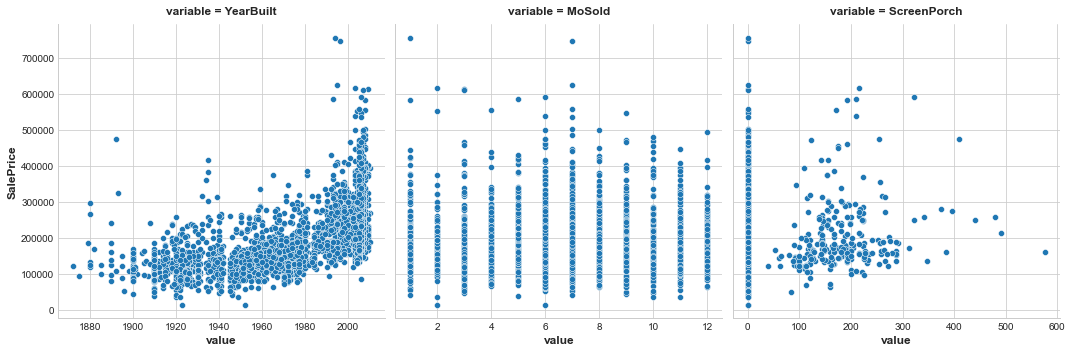

In [5]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]

#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="SalePrice", 
            col="variable", 
            data=df.melt(id_vars="SalePrice", value_vars=features),
            facet_kws=dict(sharex=False),
)
plt.show()

Based on the plots, `YearBuilt` should have the highest `MI score` since knowing the year tends to constrain `SalePrice` to a smaller range of possible values. This is generally not the case for `MoSold`, however. Finally, since `ScreenPorch` is usually just one value, 0, on average it won't tell us much about `SalePrice` (though more than MoSold) .

## 1. Mutual Information

In [6]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [7]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)
mi_scores[:5]

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
Name: MI Scores, dtype: float64

### Examine MI Scores

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


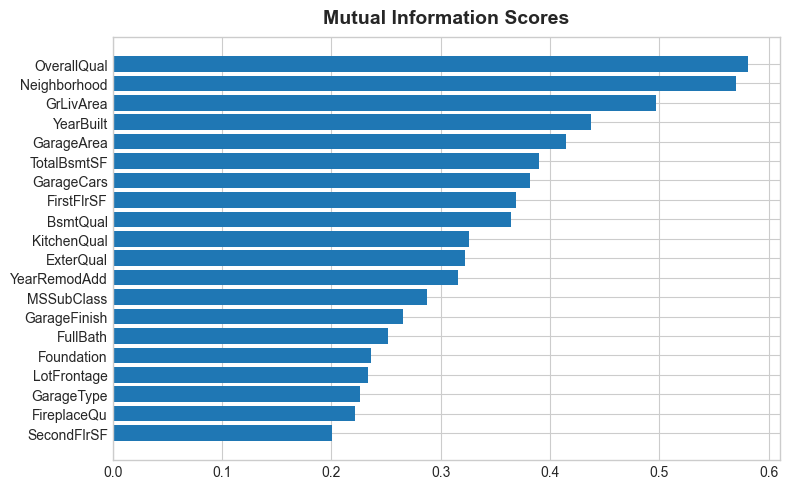

In [9]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

Some common themes among most of these features are:

   * Location: `Neighborhood`
   * Size: all of the `Area` and `SF` features, and counts like `FullBath` and `GarageCars`
   * Quality: all of the `Qual` features
   * Year: `YearBuilt` and `YearRemodAdd`
   * Types: descriptions of features and styles like `Foundation` and `GarageType`
   
These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.

ExterCond           0.020934
KitchenAbvGr        0.017677
BsmtHalfBath        0.013719
LotConfig           0.013637
ScreenPorch         0.012981
PoolArea            0.012831
MiscVal             0.010997
LowQualFinSF        0.009328
Heating             0.007622
Functional          0.006380
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC              0.001370
Utilities           0.000291
Threeseasonporch    0.000000
BsmtFinSF2          0.000000
MoSold              0.000000
LandSlope           0.000000
Name: MI Scores, dtype: float64


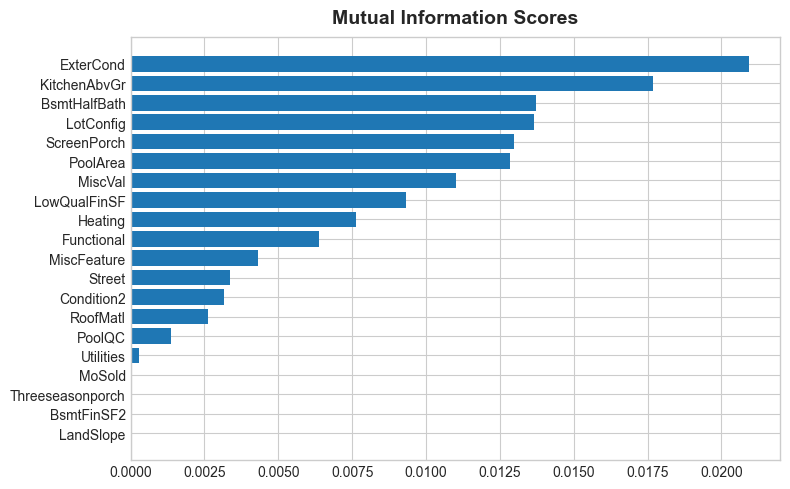

In [10]:
print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

> Bldg Type (Nominal): Type of dwelling
>		
>       1Fam	Single-family Detached	
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit
  
The `BldgType` feature didn't get a very high `MI score`. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` 

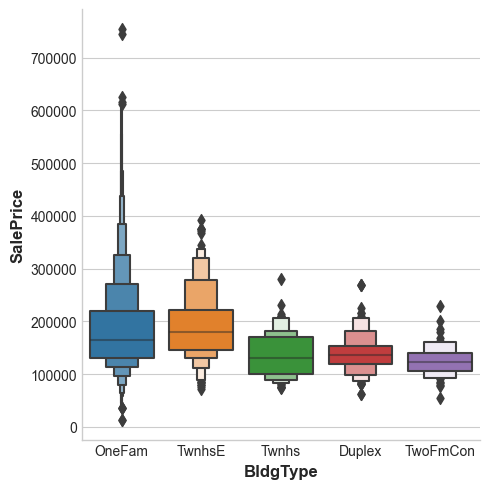

In [11]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen")
plt.show()

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

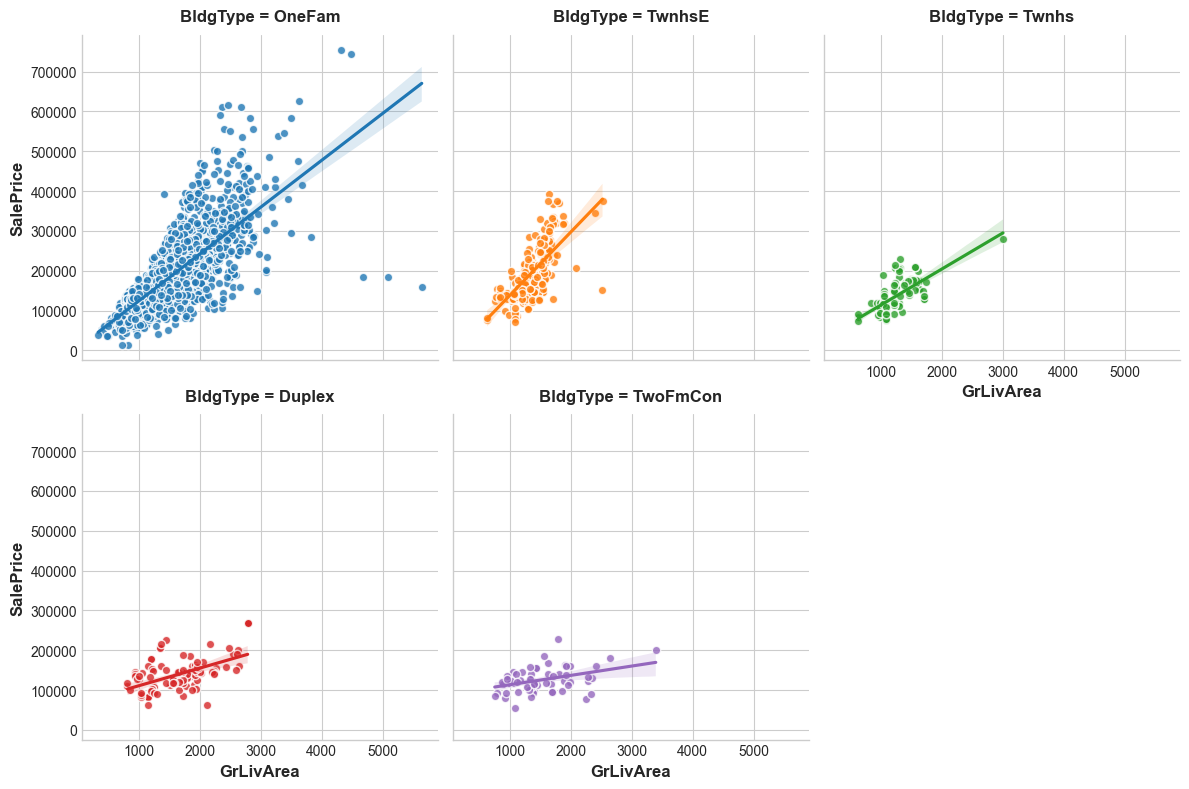

In [12]:
feature = "GrLivArea"

sns.lmplot(
    x = feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)
plt.show()

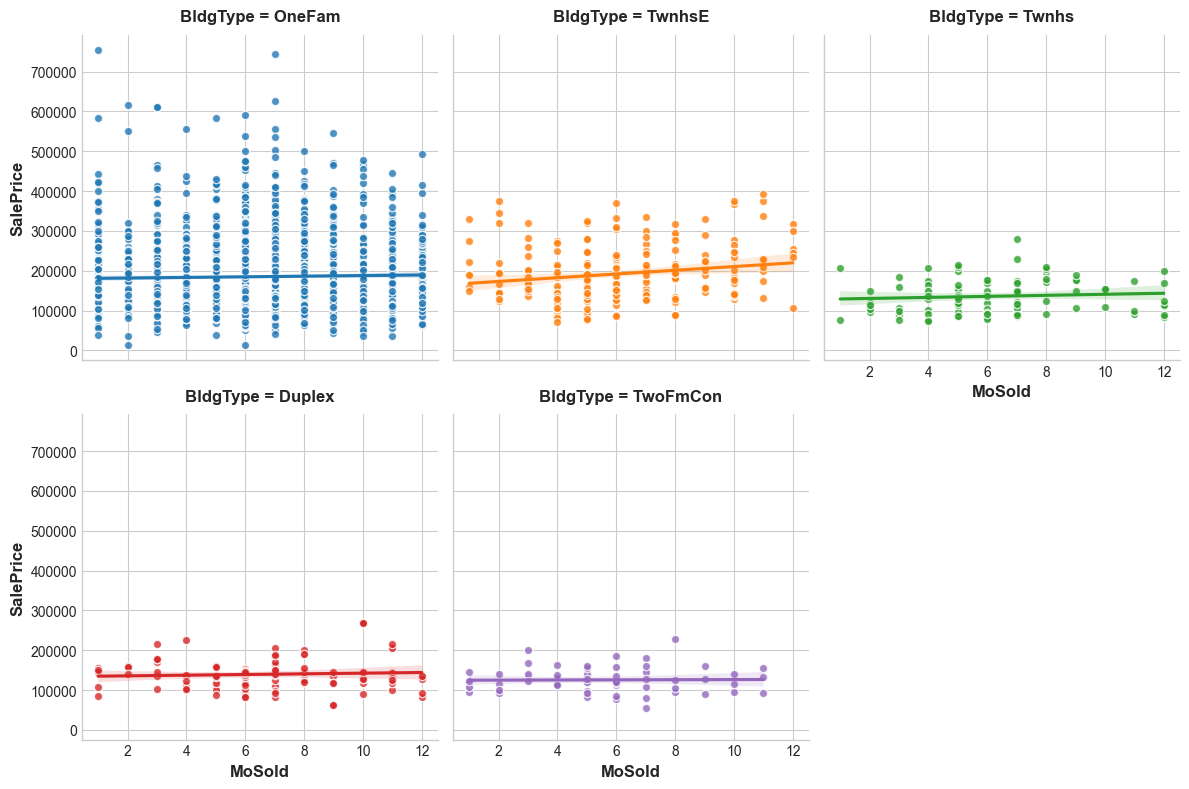

In [13]:
feature = "MoSold"

sns.lmplot(
    x = feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)
plt.show()

The trends lines within each category of `BldgType` are clearly very different, indicating an interaction between these features. Since knowing `BldgType` tells us more about how `GrLivArea` relates to `SalePrice`, we should consider including `BldgType` in our feature set.

The trend lines for `MoSold`, however, are almost all the same. This feature hasn't become more informative for knowing BldgType.

-------------------------------------------------------------------------------

Let's start with a few mathematical combinations. We'll focus on features describing areas -- having the same units (square-feet) makes it easy to combine them in sensible ways. Since we're using XGBoost (a tree-based model), we'll focus on ratios and sums.

# 1) Create Mathematical Transforms

Create the following features:

- `LivLotRatio`: the ratio of `GrLivArea` to `LotArea`
- `Spaciousness`: the sum of `FirstFlrSF` and `SecondFlrSF` divided by `TotRmsAbvGrd`
- `TotalOutsideSF`: the sum of `WoodDeckSF`, `OpenPorchSF`, `EnclosedPorch`, `Threeseasonporch`, and `ScreenPorch`

In [14]:
X_1 = pd.DataFrame()  # dataframe to hold new features

X_1["LivLotRatio"] = df['GrLivArea']/df['LotArea']
X_1["Spaciousness"] = (df['FirstFlrSF'] + df['SecondFlrSF'])/df['TotRmsAbvGrd']
X_1["TotalOutsideSF"] = df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['Threeseasonporch']+df['ScreenPorch']

-------------------------------------------------------------------------------

`Interaction effect` between a numeric feature and a categorical feature, you might want to model it explicitly using a one-hot encoding, like so:

```
# One-hot encode Categorical feature, adding a column prefix "Cat"
X_new = pd.get_dummies(df.Categorical, prefix="Cat")

# Multiply row-by-row
X_new = X_new.mul(df.Continuous, axis=0)

# Join the new features to the feature set
X = X.join(X_new)
```

# 2) Interaction with a Categorical

Discovere an interaction between `BldgType` and `GrLivArea` 

In [15]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)

# 3) Count Feature

Let's try creating a feature that describes how many kinds of outdoor areas a dwelling has. Create a feature `PorchTypes` that counts how many of the following are greater than 0.0:

```
WoodDeckSF 
OpenPorchSF
EnclosedPorch
Threeseasonporch
ScreenPorch
```

In [16]:
X_3 = pd.DataFrame()

X_3["PorchTypes"] = df[['WoodDeckSF','OpenPorchSF','EnclosedPorch','Threeseasonporch','ScreenPorch']].gt(0.0).sum(axis=1)

## 4) Break Down a Categorical Feature

`MSSubClass` describes the type of a dwelling:

In [17]:
df.MSSubClass.unique()

array(['One_Story_1946_and_Newer_All_Styles', 'Two_Story_1946_and_Newer',
       'One_Story_PUD_1946_and_Newer',
       'One_and_Half_Story_Finished_All_Ages', 'Split_Foyer',
       'Two_Story_PUD_1946_and_Newer', 'Split_or_Multilevel',
       'One_Story_1945_and_Older', 'Duplex_All_Styles_and_Ages',
       'Two_Family_conversion_All_Styles_and_Ages',
       'One_and_Half_Story_Unfinished_All_Ages',
       'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages',
       'One_Story_with_Finished_Attic_All_Ages',
       'PUD_Multilevel_Split_Level_Foyer',
       'One_and_Half_Story_PUD_All_Ages'], dtype=object)

In [18]:
X_4 = pd.DataFrame()

X_4['MSClass'] =df.MSSubClass.str.split("_", n=1, expand=True)[0]

## 5) Use a Grouped Transform

The value of a home often depends on how it compares to typical homes in its neighborhood. Create a feature `MedNhbdArea` that describes the *median* of `GrLivArea` grouped on `Neighborhood`.

In [19]:
X_5 = pd.DataFrame()

X_5["MedNhbdArea"] = df.groupby('Neighborhood')['GrLivArea'].transform("median")

### Join all X_1, X_2, X_3, X_4, X_5 and create the final dataframe X_new

In [20]:
X_new = X.join([X_1, X_2, X_3, X_4, X_5])

In [21]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [22]:
score_dataset(X_new, y)

0.13847331622461567

-------------------------------------------------------------------------------------
  
## 6) Create a Feature of Cluster Labels

Creating a k-means clustering with the following parameters:
- features: `LotArea`, `TotalBsmtSF`, `FirstFlrSF`, `SecondFlrSF`,`GrLivArea`
- number of clusters: 10
- iterations: 10

In [23]:
from sklearn.cluster import KMeans

In [24]:
X = df.copy()
y = X.pop("SalePrice")

In [25]:
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF','GrLivArea']
X[features].sample(5)

,LotArea,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea
2293,15957.0,1244.0,1356.0,0.0,1356.0
2330,18062.0,1528.0,1528.0,1862.0,3390.0
1254,10122.0,0.0,869.0,0.0,869.0
2101,11175.0,1316.0,1316.0,0.0,1316.0
747,11888.0,844.0,1445.0,689.0,2134.0


In [26]:
# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

In [27]:
#Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(10, random_state=0)

X["Cluster"] = kmeans.fit_predict(X_scaled)

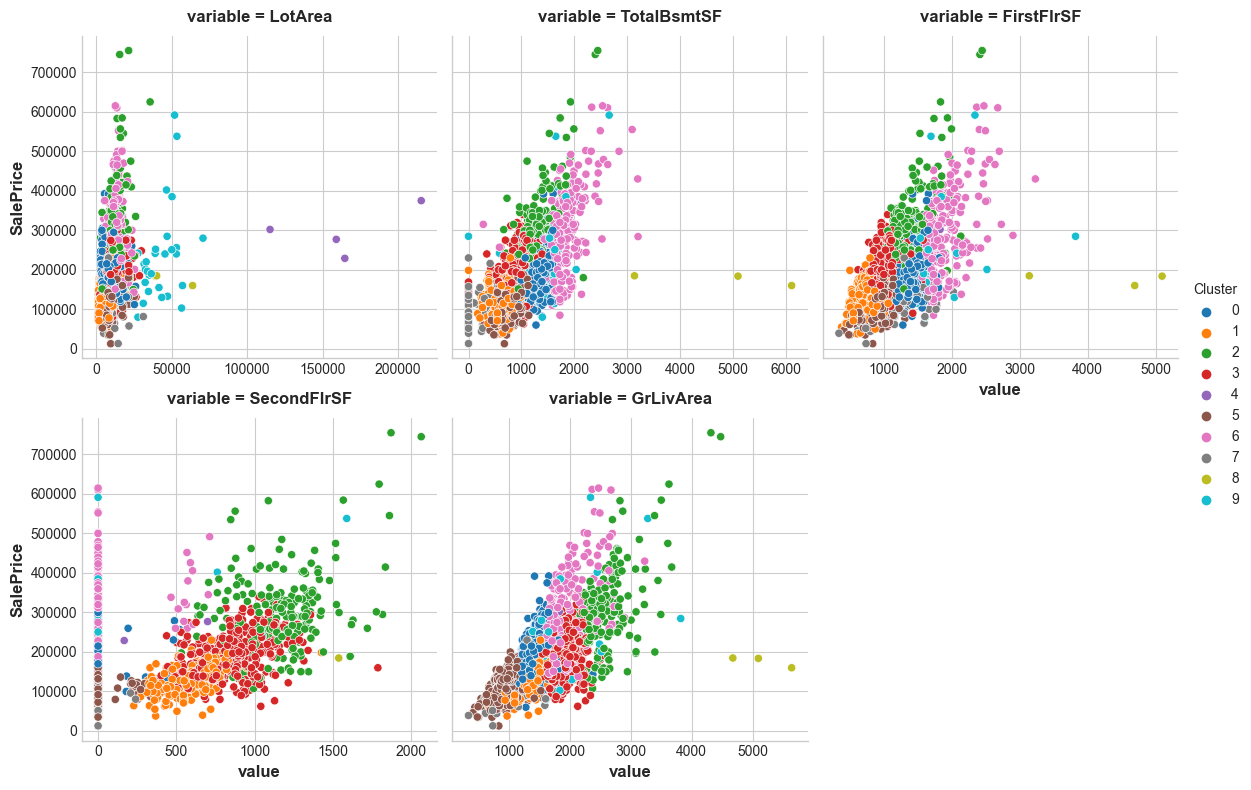

In [28]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"]
    ),
)
plt.show()

In [29]:
score_dataset(X, y)

0.1404632128875517

-------------------------------------------------------------------------------

The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

## 7) Cluster-Distance Features

Now add the cluster-distance features to your dataset. You can get these distance features by using the `fit_transform` method of `kmeans` instead of `fit_predict`.

In [30]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

#Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

In [31]:
X.sample(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9
1138,0,0,81.0,9260.0,0,0,1,0,0,0,...,0.894156,2.151077,4.054731,2.510962,19.731971,0.833839,2.818910,2.393907,14.875494,4.768608
1606,0,0,60.0,6600.0,0,0,1,0,0,1,...,2.171660,1.788130,4.848202,2.879907,20.254185,0.508709,4.107857,1.975325,16.152670,5.646612


In [32]:
score_dataset(X, y)

0.1414333744272644